In [3]:
import numpy as np
x = np.random.rand(10, 1, 28, 28)  # 무작위 데이터 생성
print(x.shape)

# 첫 번째 데이터, 두 번째 데이터
print(x[0].shape)  # (1, 28, 28)
print(x[1].shape)  # (1, 28, 28)

# 첫 번째 데이터의 첫 채널의 공간 데이터
print(x[0, 0])  # or x[0][0]. 28 * 28의 벡터

(10, 1, 28, 28)
(1, 28, 28)
(1, 28, 28)
[[4.30751805e-01 9.54691164e-01 1.07160631e-01 2.07463694e-01
  8.58208367e-02 8.65999145e-01 7.13200235e-01 7.23553942e-01
  3.12721385e-01 8.88012453e-01 3.49322911e-01 6.89275044e-01
  9.66458697e-01 9.75265058e-01 5.95708005e-01 4.08299834e-01
  5.55877186e-01 9.39565028e-01 7.34108682e-01 1.53426771e-01
  5.29859770e-02 8.59942910e-02 7.43263099e-01 9.53770419e-01
  4.16301412e-01 8.17622535e-01 6.55093728e-02 6.55306137e-01]
 [1.25678170e-01 9.42982194e-01 6.52599121e-01 8.76356425e-01
  1.69244674e-02 8.30614796e-01 8.83184577e-01 9.13284380e-01
  5.60869610e-01 5.05393412e-01 7.11621752e-01 4.19376936e-01
  2.66739708e-01 8.73366043e-01 9.28183047e-01 6.23759177e-01
  1.61572827e-01 7.94888758e-01 5.41548899e-01 5.15474371e-01
  8.15404208e-02 5.66253268e-01 5.74554295e-02 5.48614779e-02
  8.21929944e-01 6.19941273e-01 5.49201651e-01 3.72896104e-01]
 [1.05308018e-01 5.52587676e-01 2.03049285e-01 8.24955844e-01
  5.87615660e-01 8.46355207e

In [4]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h) / stride + 1
    out_w = (W + 2*pad - filter_w) / stride + 1

    img = np.pad(input_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


In [11]:
from util import im2col

x1 = np.random.rand(1, 3, 7, 7)  # (데이터 수, 채널 수, 높이, 너비)
col1 = im2col(x1, 5, 5)
print(col1.shape)  # (9, 75)

x2 = np.random.rand(10, 3, 7, 7)  # 데이터 10개
col2 = im2col(x2, 5, 5)
print(col2.shape)  # (90, 75)


(9, 75)
(90, 75)


In [12]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2 * self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2 * self.pad - FW) / self.stride)

        # 입력 데이터와 필터를 2차원 배열로 전개하고 내적한다.
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T  # 필터 전개
        out = np.dot(col, col_W) + self.b

        # reshape에서 -1 : 원소 개수에 맞춰 적절하게 묶어줌.
        # transpose : 다차원 배열의 축 순서를 바꿔줌(N,H,W,C) -> (N,C,H,W)
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        return out

In [14]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        # 전개
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)

        # 최댓값 axis : 축의 방향, 0=열방향, 1=행방향
        out = np.max(col, axis=1)

        # 성형
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        return out

In [23]:
import sys
import os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient
from dataset.mnist import load_mnist
from common.trainer import Trainer

class SimpleConvNet:
    """
    다음과 같은 CNN을 구성한다.
    → Conv → ReLU → Pooling → Affine → ReLU → Affine → Softmax →
    전체 구현은 simple_convnet.py 참고
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param={'filter_num': 30, 'filter_size': 5,
                             'pad': 0, 'stride': 1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        # 초기화 인수로 주어진 하이퍼파라미터를 딕셔너리에서 꺼내고 출력 크기를 계산한다.
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / \
            filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) *
                               (conv_output_size/2))

        # 1층의 합성곱 계층과 2, 3층의 완전연결 계층의 가중치와 편향 생성
        self.params = {}
        self.params['W1'] = weight_init_std * \
            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # CNN을 구성하는 계층을 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'],
                                           self.params['b1'],
                                           conv_param['stride'],
                                           conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()

    def load_params(self, file_name):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, value in params.items():
            self.params[key] = value
            
    def predict(self, x):
        """추론을 수행"""
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        """손실함수 값 계산"""
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1:
            t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        """오차역전파법으로 기울기를 구함"""
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db

        return grads


train loss:2.299445063171202
=== epoch:1, train acc:0.323, test acc:0.31 ===
train loss:2.2977522640786274
train loss:2.2913439004132137
train loss:2.2827597146169167
train loss:2.2795136321094303
train loss:2.2607204186746066
train loss:2.254753103828473
train loss:2.2362725918517175
train loss:2.203640236659547
train loss:2.2052355101964207
train loss:2.1891301860846712
train loss:2.1208774488582964
train loss:2.069786558935376
train loss:1.9952959005635937
train loss:1.9898777979192916
train loss:1.8791884242499315
train loss:1.8280509375712282
train loss:1.7752435029701976
train loss:1.7404788234690616
train loss:1.6872842755680588
train loss:1.4439486871878435
train loss:1.4390011025233962
train loss:1.3639415473271481
train loss:1.3203063961211532
train loss:1.2987128077788386
train loss:1.2278798107811928
train loss:1.0603185767535919
train loss:1.0164783912535276
train loss:1.0004505030465005
train loss:0.8711728973490093
train loss:0.9130593220621437
train loss:0.8501335088207

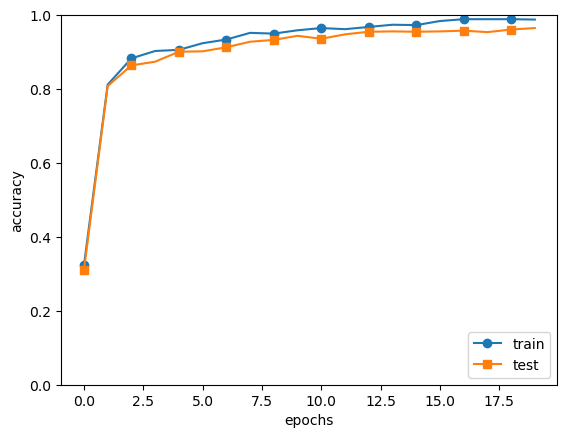

In [16]:
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1, 28, 28),
                        conv_param={'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

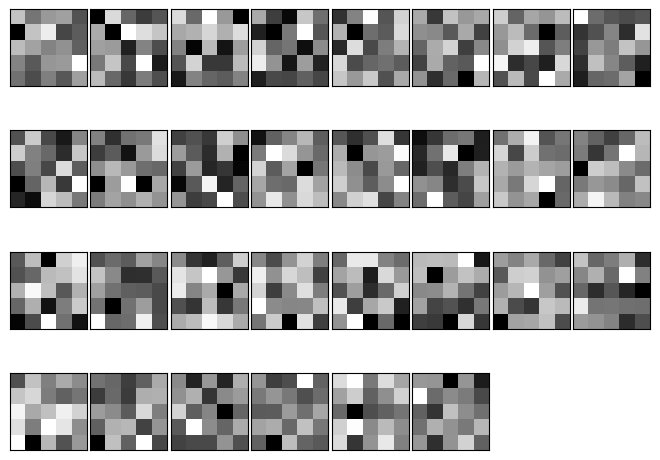

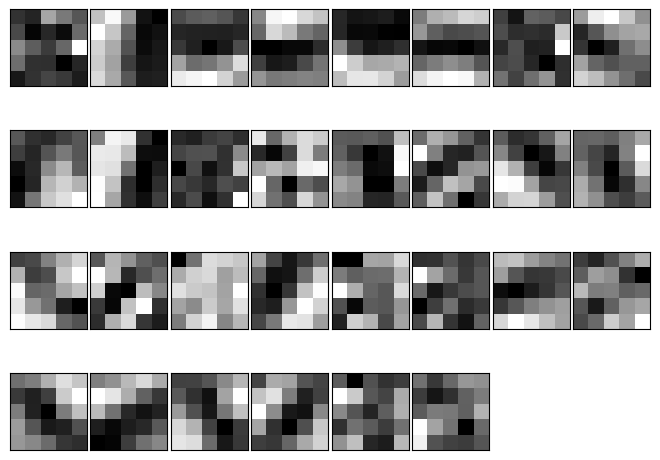

In [24]:
def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])

이미지 입력 없이 새로운 이미지를 그려내는 연구.
DCGAN(Deep Convolutional Generative Adversarial Network) 기법을 통해 학습 데이터에는
존재하지 않는 새로운 침실 이미지들을 생성했다.

DCGAN은 생성자Generator와 식별자Discriminator라 불리는 2개의 신경망을 이용한다.
생성자가 이미지를 생성하고 식별자는 진짜인지를 판별한다. 둘을 겨루도록 학습시켜 생성자는
더 정교한 이미지 생성을, 식별자는 더 정확한 판별을 하게 된다.
이런 개념을 GAN(Generative Adversarial Network)이라 한다.

NOTE : 이전까지의 기계학습은 지도 학습supervised learning이라는 유형의 문제였다.
하지만 이번 절의 문제는 지도용 데이터는 주어지지 않고 대량의 이미지만 주어진다.
즉, 지도 없이 스스로 학습하는 자율 합스unsupervised learning문제이다.

강화학습reinforcement learning : 가르침에 의존하는 지도 학습과는 다른게 시행착오를 통해
스스로 학습하게 하는 시도.
에이전트는 환경에 맞게 행동을 선택하고 행동에 의해 환경이 변화한다. 환경이 변화하면 에이전트는
어떤 보상을 얻는다. 강화학습의 목적은 더 나은 보상을 받는 쪽으로 에이전트의 지침을 설정하는 것이다.

행동의 보상은 항상 명확한 것이 아니기 때문에 게임 점수나 게임 종료 등 명확한 지표로부터
역산해 예상 보상을 정해야 한다.

DQN : Q학습이라는 강화학습 알고리즘을 기초로 한다. Q학습은 최적 행동 가치 함수로 행동을
결정하는데 이를 CNN으로 흉내낸다.